In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import numpy as np
from aion.modalities import LegacySurveyImage
import h5py
from tqdm import tqdm
import umap

In [4]:
test_file = h5py.File('../../semi_supervised_test_i_snr_20.hdf5', 'r+')


In [5]:
im = test_file['images'][0,1:5,:,:]
im.shape

(4, 108, 108)

In [7]:
# Convert im to a torch tensor, adding a batch dimension, and sending to GPU
image_flux = torch.tensor(im.astype("float32")).unsqueeze(0).to("cpu")

# Create a typed image which keeps track of metadata
image = LegacySurveyImage(flux=image_flux, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [9]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cpu")

# Apply a codec on our prepared image
# This will automatically download the necessary codec
tokens = codec_manager.encode(image)

In [10]:
reconstructed_image = codec_manager.decode(
    tokens,
    LegacySurveyImage,  # The modality from the 'tokens' dictionary we want to decode
    bands=["DES-G", "DES-R", "DES-I", "DES-Z"],
)  # Metadata required to reconstruct the given modality

In [11]:
rec_im = reconstructed_image.flux.detach().cpu().numpy()
rec_im.shape

(1, 4, 96, 96)

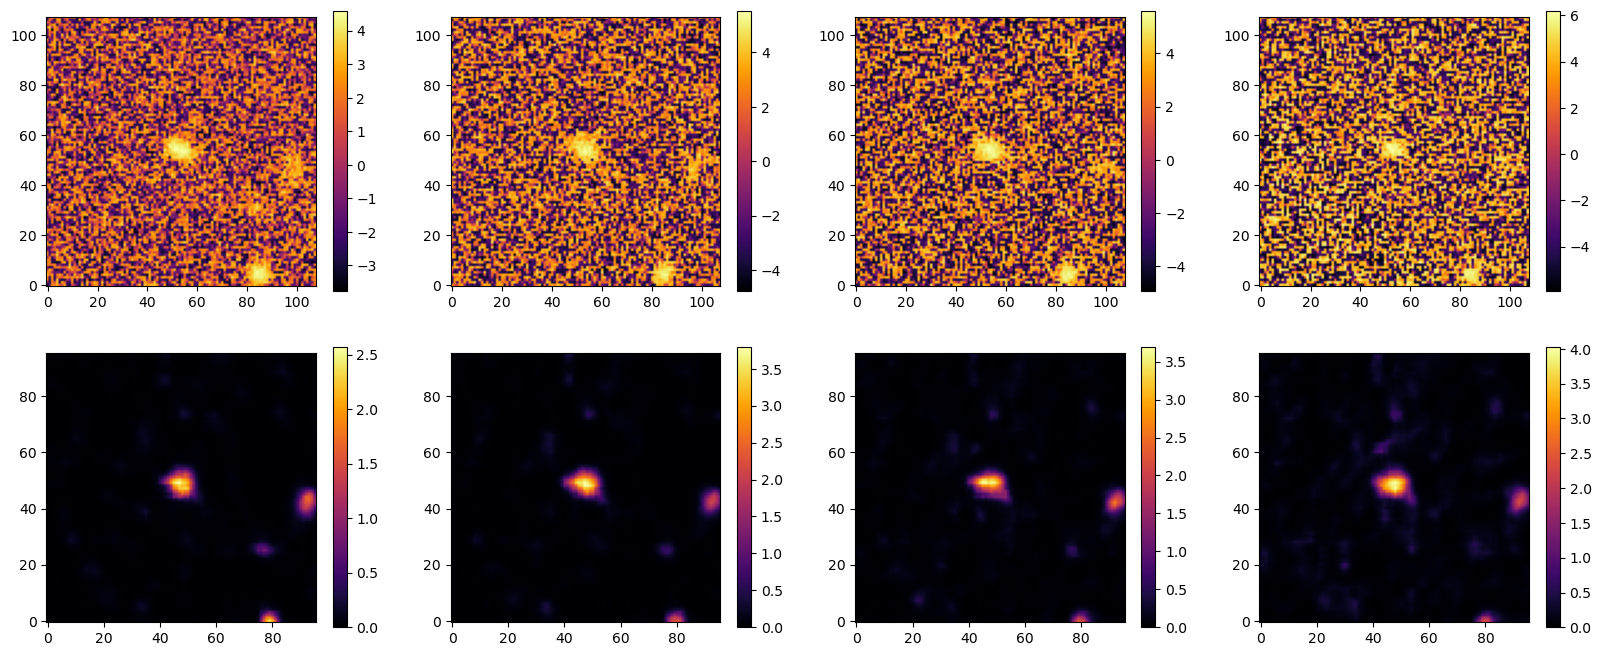

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

for i in range(4):
    sd = ax[0,i].imshow(np.arcsinh(im[i,:,:]), origin='lower', cmap='inferno')
    fig.colorbar(sd, ax=ax[0,i])

    sd = ax[1,i].imshow(np.arcsinh(rec_im[0,i,:,:]), origin='lower', cmap='inferno')
    fig.colorbar(sd, ax=ax[1,i])

In [14]:
from aion.model import AION

# Disable gradients for this notebook
torch.set_grad_enabled(False)

# Importing model
model = AION.from_pretrained("polymathic-ai/aion-base").to("cpu").eval()


In [15]:
pred = model.encode(tokens, num_encoder_tokens=600)

In [18]:
ims = torch.tensor(test_file['images'][:,1:5,:,:].astype('float32')).to("cpu")
images = LegacySurveyImage(flux=ims, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [ ]:
# Instantiate the manager
codec_manager = CodecManager(device="cpu")
batch_size = 32
n = ims.shape[0]
im_embeddings = []
for i in tqdm(range(0, n, batch_size)):
    images = LegacySurveyImage(flux=ims[i : min(n,i+batch_size)], bands=["DES-G", "DES-R", "DES-I", "DES-Z"])
    im_embeddings.append(
        model.encode(codec_manager.encode(images), num_encoder_tokens=600).mean(axis=1)
    )

 88%|████████▊ | 78/89 [53:26<07:51, 42.90s/it]

In [ ]:
im_embeddings = torch.cat(im_embeddings, dim=0).cpu().numpy()


In [40]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(im_embeddings)
embedding.shape


(2830, 2)

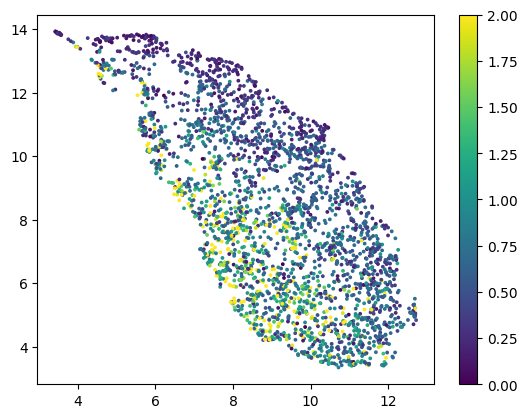

In [44]:
fig, ax = plt.subplots()

sd = ax.scatter(embedding[:,0], embedding[:,1], s=3, c=test_file['redshifts'][:], vmin=0, vmax=2)
fig.colorbar(sd, ax=ax)
